In [1]:
import simexpal
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
def parse(run):
    
    # Get all used parameter
    var_dict = dict()
    for var in run.experiment.variation:
        var_dict[var.axis] = var.name
    #print(var_dict)

    output_dict = dict()
    # Read output
    oFile = run.open_output_file()
    affected_nodes_values = [0] * 50
    dyn_runtime_values = [0.0] * 50
    speedup_values = [0.0] * 50
    static_runtime = 0.0
    
    for line in oFile:
        if line.startswith("(Dynamic) affected nodes per run:"):
            for i in range(50):
                next_line = next(oFile).strip()
                if next_line:
                    value = int(next_line)
                    affected_nodes_values[i] = value
            #avg_affected_nodes = affected_nodes_values / 50
        elif line.startswith("(Dynamic) runtimes [s] per run:"):
            for i in range(50):
                next_line = next(oFile).strip()
                if next_line:
                    value = float(next_line)
                    dyn_runtime_values[i] = value
            #avg_runtime = dyn_runtime_values / 50.0
        elif line.startswith("(Static) runtimes [s] per run:"):
            next_line = next(oFile).strip()
            static_runtime = float(next_line)

    for idx, val in enumerate(dyn_runtime_values):
        speedup_values[idx] = static_runtime / val
    
    return {
        'experiment': run.experiment.name,
        'instance': run.instance.shortname,
        'group': list(run.instance.instsets)[0],
        'b': var_dict['b_value'].split('3_b_val=')[1],
        'operation': var_dict['operation'].split('1_op=')[1],
        'batch_size': var_dict['batch_size'].split('2_batch_s=')[1],
        'affected_nodes': affected_nodes_values,
        'dyn_runtime': dyn_runtime_values,
        'speedup': speedup_values,
        'static_runtime': static_runtime
    }

In [3]:
cfg = simexpal.config_for_dir("./")
results = []

In [4]:
for successful_run in cfg.collect_successful_results():
    results.append(parse(successful_run))

In [5]:
#pd.set_option('display.max_rows', None)
df = pd.DataFrame(results)
df = df.sort_values(by=['group'])

groupSeries = np.sort(pd.unique(df.group)).astype(str)
df['group'] = pd.Categorical(df['group'], categories=groupSeries, ordered=True)
#df['b'] = pd.Categorical(df['b'], ["1", "2", "3", "10", "random"], ordered=True)

df

,experiment,instance,group,b,operation,batch_size,affected_nodes,dyn_runtime,speedup,static_runtime
214,dynamic-b-suitor,rmat-g,random,10,insert,10e2,"[143, 139, 140, 134, 132, 127, 122, 136, 127, ...","[0.000546525, 0.000548653, 0.000509932, 0.0005...","[98415.44302639403, 98033.7298802704, 105477.7...",53.78650
88,dynamic-b-suitor,rmat-g,random,random,insert,10e0,"[0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, ...","[1.8524e-05, 2.4662e-05, 3.302e-06, 8.779e-06,...","[1813814.5109047722, 1362383.4238910065, 10175...",33.59910
87,dynamic-b-suitor,rmat-er,random,random,insert,10e0,"[0, 0, 0, 4, 0, 4, 0, 0, 2, 4, 2, 0, 0, 0, 4, ...","[1.1328e-05, 2.94e-06, 3.246e-06, 4.2353e-05, ...","[3829210.8050847454, 14754183.673469389, 13363...",43.37730
86,dynamic-b-suitor,rmat-b,random,random,insert,10e0,"[0, 0, 2, 0, 2, 0, 0, 0, 3, 0, 3, 2, 2, 2, 3, ...","[9.047e-06, 3.895e-06, 1.1607e-05, 2.738e-06, ...","[2062197.4135072401, 4789910.141206675, 160736...",18.65670
466,dynamic-b-suitor,rmat-g,random,1,remove,10e1,"[8, 4, 5, 0, 1, 5, 1, 4, 3, 4, 2, 5, 1, 3, 1, ...","[9.4502e-05, 4.3666e-05, 5.3548e-05, 3.828e-06...","[90266.97847664599, 195355.8832959282, 159303....",8.53041
...,...,...,...,...,...,...,...,...,...,...
543,dynamic-b-suitor,bone010,real_sparse,1,remove,10e2,"[395, 386, 412, 332, 322, 420, 299, 402, 276, ...","[0.00463947, 0.00478871, 0.00478232, 0.0039659...","[1379.2523714993308, 1336.2680137239465, 1338....",6.39900
544,dynamic-b-suitor,cage14,real_sparse,1,remove,10e2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.8743e-05, 2.3437e-05, 2.4129e-05, 2.3182e-0...","[219022.53310275407, 362059.56393736403, 35167...",8.48559
545,dynamic-b-suitor,cage15,real_sparse,1,remove,10e2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4.3008e-05, 2.4312e-05, 2.128e-05, 2.2137e-05...","[671577.380952381, 1188022.375781507, 1357293....",28.88320
279,dynamic-b-suitor,human_gene2,real_sparse,1,insert,10e3,"[17, 14, 26, 18, 26, 31, 13, 26, 25, 10, 33, 1...","[0.000385353, 0.000458736, 0.000905255, 0.0005...","[1322.060552272851, 1110.5734016950926, 562.78...",0.50946


In [6]:
df_affected = df.groupby(['group','b','operation','batch_size']).agg({'affected_nodes' : 'sum'})
df_affected.reset_index(inplace=True)
for i, row in df_affected.iterrows():
    local_b = [row['b']] * len(row['affected_nodes'])
    df_affected['b'][i] = local_b

/tmp/ipykernel_2919044/1549489707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_affected['b'][i] = local_b


In [7]:
df_speedup = df.groupby(['group','b','operation','batch_size']).agg({'speedup' : 'sum'})
df_speedup.reset_index(inplace=True)
for i, row in df_speedup.iterrows():
    local_b = [row['b']] * len(row['speedup'])
    df_speedup['b'][i] = local_b

/tmp/ipykernel_2919044/2632830081.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speedup['b'][i] = local_b


### Affected nodes plot

#### Edge Insertion

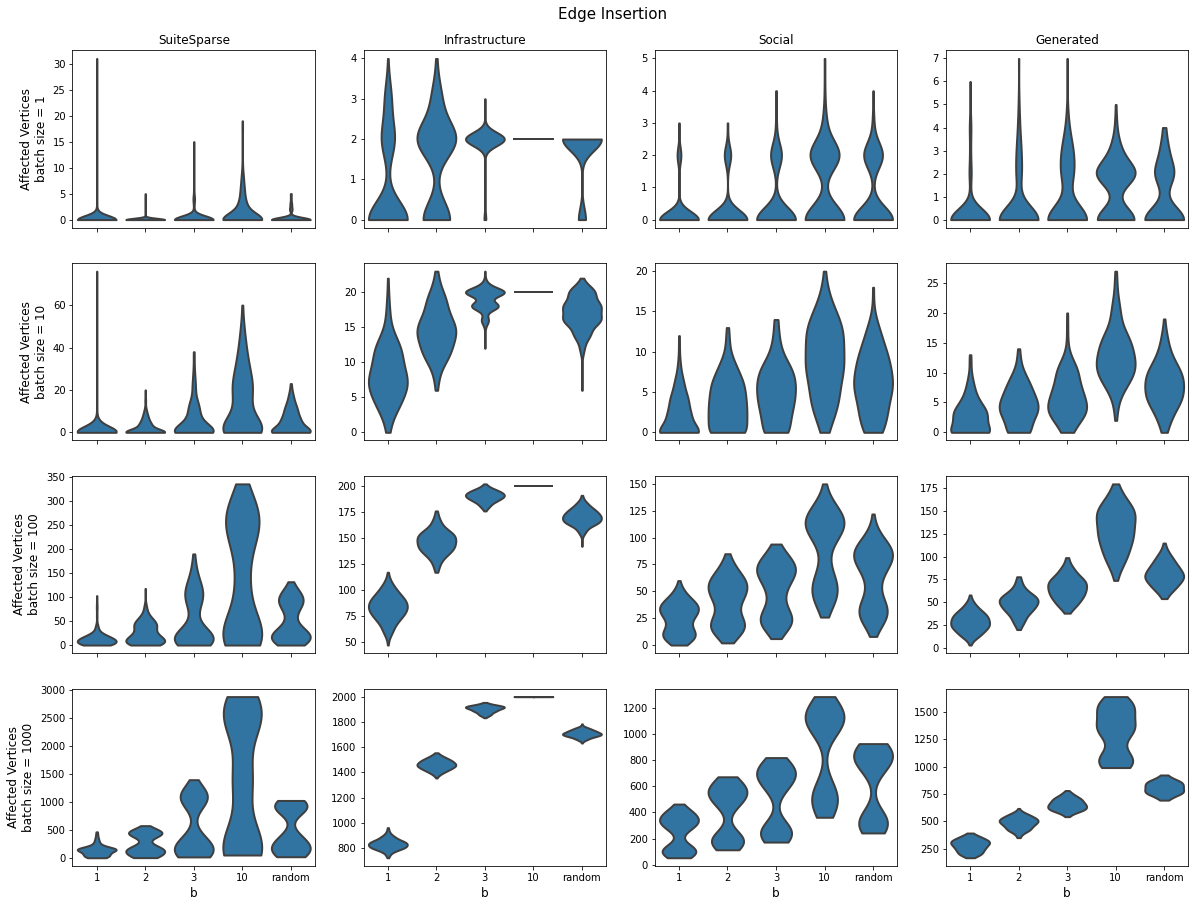

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(20, 15), sharex='all')

cols = ['{}'.format(col) for col in ['SuiteSparse', 'Infrastructure', 'Social', 'Generated']]
rows = ['{}'.format(col) for col in ['Affected Vertices\nbatch size = 1', 'Affected Vertices\nbatch size = 10', 'Affected Vertices\nbatch size = 100', 'Affected Vertices\nbatch size = 1000']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=12, labelpad=5)

for ax in axs[3,:]:
    ax.set_xlabel('b', fontsize=12)
    
fig.suptitle("Edge Insertion", y=0.92, fontsize=15)
    
def plotter(localDf):
    op = "insert"
    if (localDf['batch_size'] == '10e0').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 0], order=[ '1', '2', '3', '10', 'random'])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 3])
    if (localDf['batch_size'] == '10e1').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 3])
    if (localDf['batch_size'] == '10e2').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 3])
    if (localDf['batch_size'] == '10e3').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 3]) 

        
df_affected.groupby('batch_size').apply(plotter)
plt.savefig('./plots/affected_insertion.pdf', format="pdf", bbox_inches='tight')

#### Edge Removal

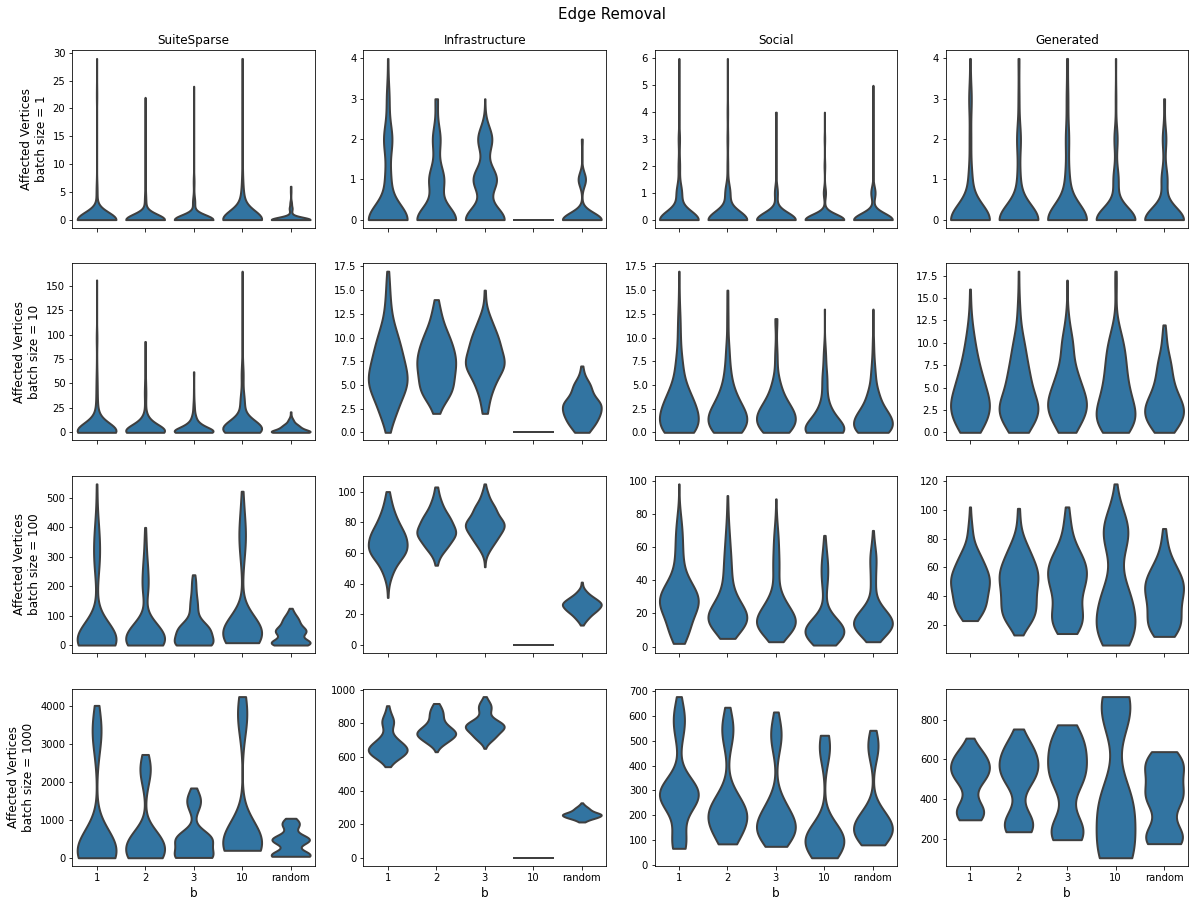

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(20, 15), sharex='all')

cols = ['{}'.format(col) for col in ['SuiteSparse', 'Infrastructure', 'Social', 'Generated']]
rows = ['{}'.format(col) for col in ['Affected Vertices\nbatch size = 1', 'Affected Vertices\nbatch size = 10', 'Affected Vertices\nbatch size = 100', 'Affected Vertices\nbatch size = 1000']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=12, labelpad=5)

for ax in axs[3,:]:
    ax.set_xlabel('b', fontsize=12)

fig.suptitle("Edge Removal", y=0.92, fontsize=15)
    
def plotter(localDf):
    op = "remove"
    if (localDf['batch_size'] == '10e0').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 0], order=[ '1', '2', '3', '10', 'random'])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 3])
    if (localDf['batch_size'] == '10e1').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 3])
    if (localDf['batch_size'] == '10e2').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 3])
    if (localDf['batch_size'] == '10e3').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['affected_nodes'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 3]) 

        
df_affected.groupby('batch_size').apply(plotter)
plt.savefig('./plots/affected_removal.pdf', format="pdf", bbox_inches='tight')

### Speedup

#### Edge Insertion

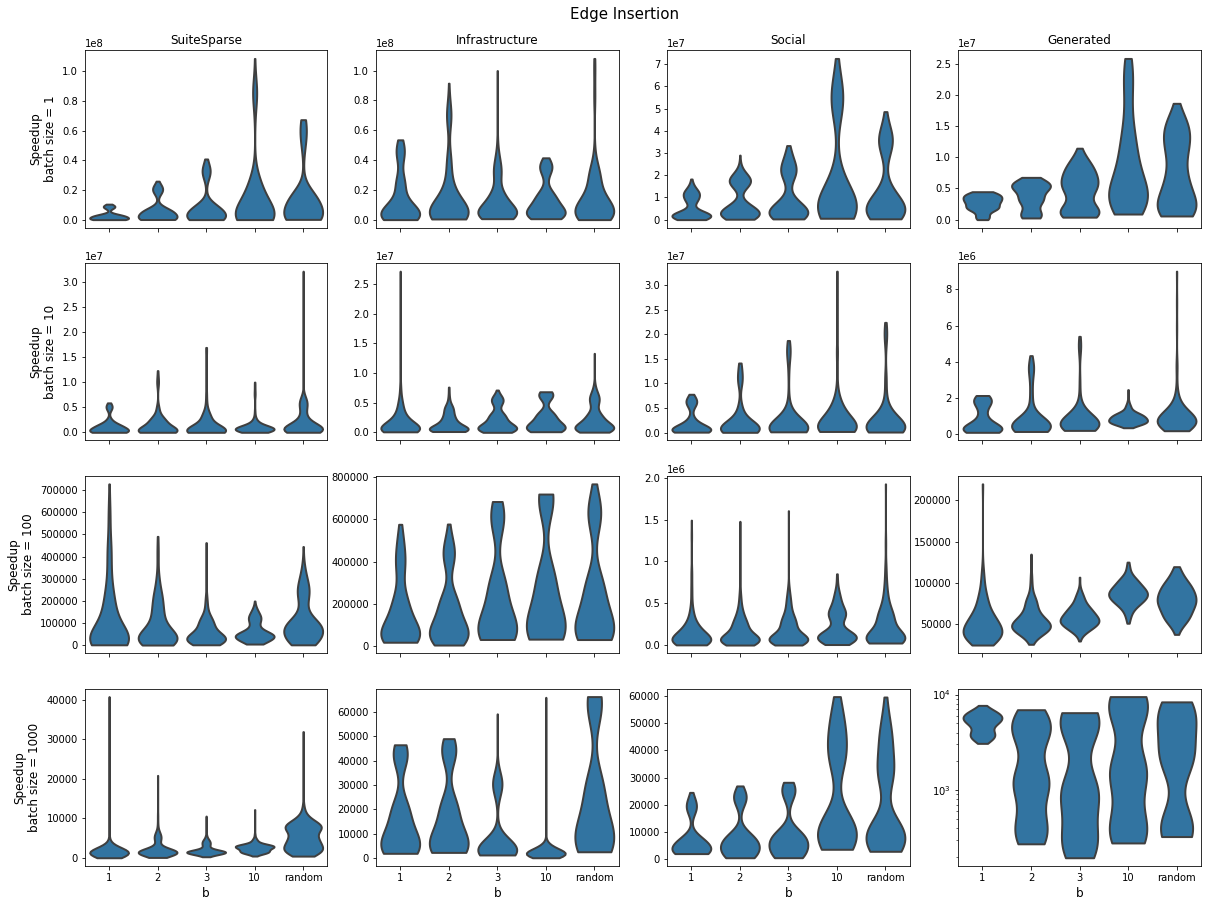

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(20, 15), sharex='all')

cols = ['{}'.format(col) for col in ['SuiteSparse', 'Infrastructure', 'Social', 'Generated']]
rows = ['{}'.format(col) for col in ['Speedup\nbatch size = 1', 'Speedup\nbatch size = 10', 'Speedup\nbatch size = 100', 'Speedup\nbatch size = 1000']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=12, labelpad=5)

for ax in axs[3,:]:
    ax.set_xlabel('b', fontsize=12)

fig.suptitle("Edge Insertion", y=0.92, fontsize=15)
    
def plotter(localDf):
    op = "insert"
    if (localDf['batch_size'] == '10e0').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 0], order=[ '1', '2', '3', '10', 'random'])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 3])
    if (localDf['batch_size'] == '10e1').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 3])
    if (localDf['batch_size'] == '10e2').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 3])
    if (localDf['batch_size'] == '10e3').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 3]) 
  
df_speedup.groupby('batch_size').apply(plotter)
plt.savefig('./plots/speedup_insertion.pdf', format="pdf", bbox_inches='tight')

#### Edge Removal

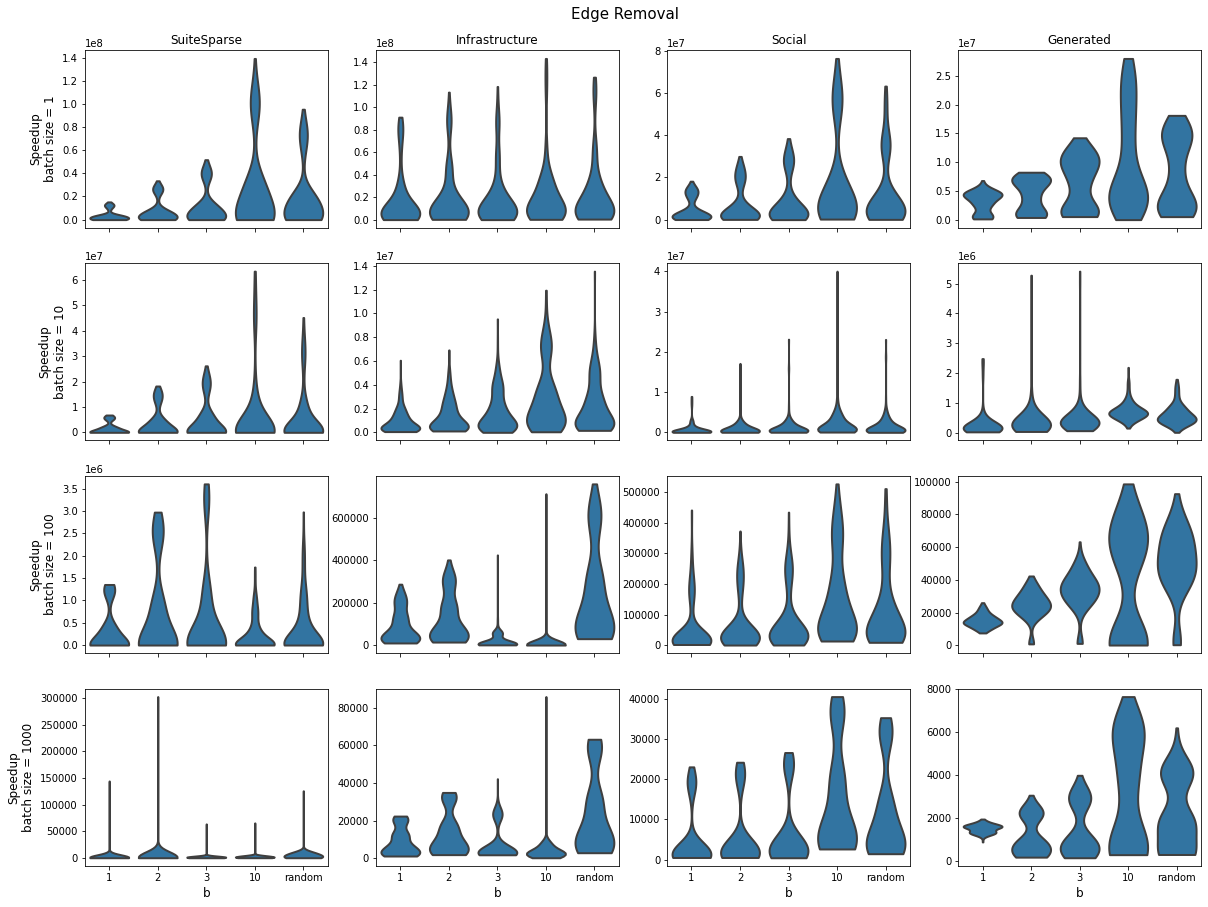

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(20, 15), sharex='all')

cols = ['{}'.format(col) for col in ['SuiteSparse', 'Infrastructure', 'Social', 'Generated']]
rows = ['{}'.format(col) for col in ['Speedup\nbatch size = 1', 'Speedup\nbatch size = 10', 'Speedup\nbatch size = 100', 'Speedup\nbatch size = 1000']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=12, labelpad=5)

for ax in axs[3,:]:
    ax.set_xlabel('b', fontsize=12)
    
fig.suptitle("Edge Removal", y=0.92, fontsize=15)
    
def plotter(localDf):
    op = "remove"
    if (localDf['batch_size'] == '10e0').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 0], order=[ '1', '2', '3', '10', 'random'])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[0, 3])
    if (localDf['batch_size'] == '10e1').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[1, 3])
    if (localDf['batch_size'] == '10e2').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[2, 3])
    if (localDf['batch_size'] == '10e3').all():
        localSparse = localDf.query('group == "real_sparse" and operation == @op')
        localInfra = localDf.query('group == "real_infrastructure" and operation == @op')
        localSocial = localDf.query('group == "real_social" and operation == @op')
        localRandom = localDf.query('group == "random" and operation == @op')
        sns.violinplot(x=localSparse['b'].sum(), y=localSparse['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 0])
        sns.violinplot(x=localInfra['b'].sum(), y=localInfra['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 1])
        sns.violinplot(x=localSocial['b'].sum(), y=localSocial['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 2])
        sns.violinplot(x=localRandom['b'].sum(), y=localRandom['speedup'].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[3, 3]) 

        
df_speedup.groupby('batch_size').apply(plotter)
plt.savefig('./plots/speedup_removal.pdf', format="pdf", bbox_inches='tight')